# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [765]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [766]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [767]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: 

Мы тут используем метод, который возвращает вероятности принадлежности к классам, в частности, мы возвращаем вероятности для класса 1, а чтобы получить бинарные метки (0 или 1), нужно установить порог (например, 0.5) и преобразовать вероятности в метки.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [768]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


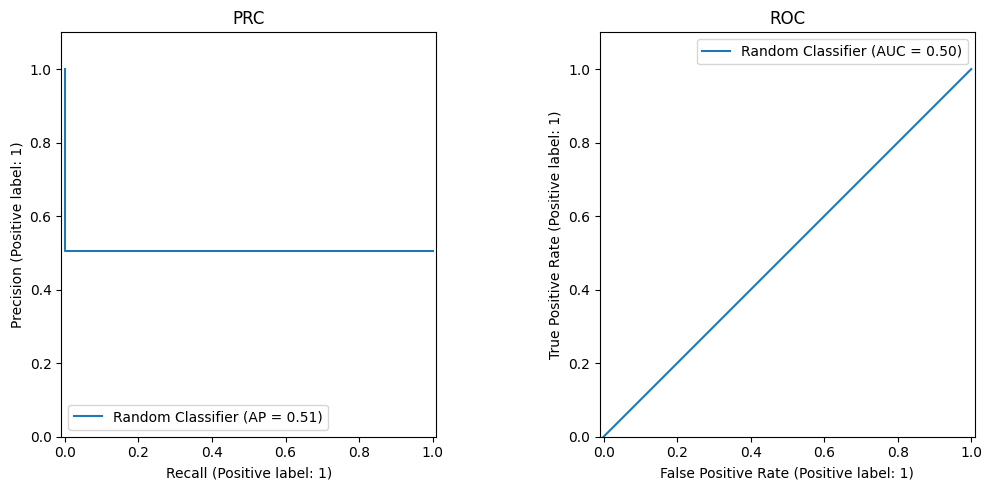

In [769]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [770]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [771]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [772]:
param_grid = {'C': np.logspace(-3, 5, 10)} 
mod = LinearSVC()
grid_search = GridSearchCV(estimator=mod, param_grid=param_grid, scoring='average_precision', cv=5)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
print(f"Лучший параметр C: {best_C}")

SVC_model = LinearSVC(max_iter = 1000000, C = best_C)
SVC_model.fit(X_train, y_train)
y_pred_proba = SVC_model.decision_function(X_test)

df_metrics_new = pd.DataFrame(columns=['auc_pr', 'roc_auc_score', 'reg_const'])
y_random = np.random.randint(0, 2, size=y_test.shape)
df_metrics_new.loc['SVC with Linear Kernel'] = [
    average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    best_C,
]

df_metrics_new

Лучший параметр C: 27.825594022071257


,auc_pr,roc_auc_score,reg_const
SVC with Linear Kernel,0.829949,0.847645,27.825594


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVC with Linear Kernel metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


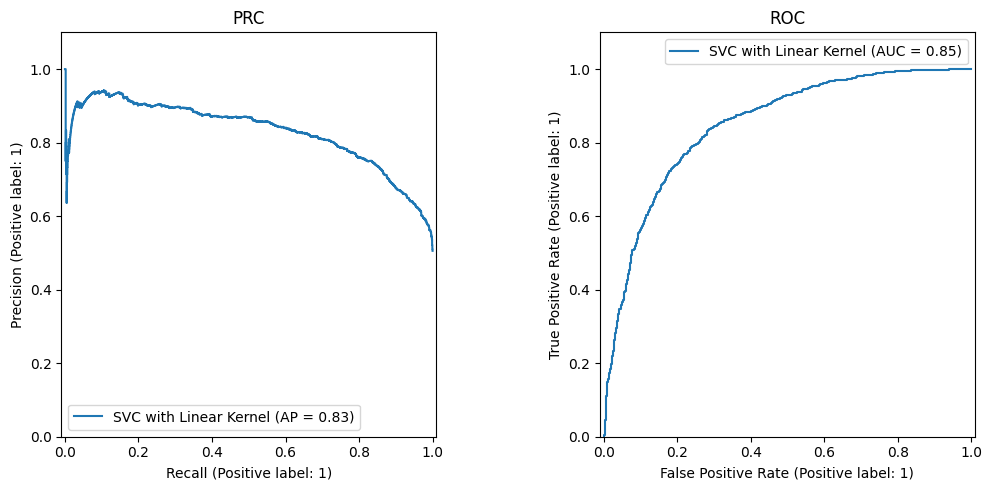

In [773]:
depict_pr_roc(y_test, y_pred_proba, classifier_name='SVC with Linear Kernel')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

- AUC-ROC: 
Площадь под ROC кривой, которая показывает, как хорошо модель различает классы. Значения AUC варьируются от 0 до 1, где 1 означает идеальную модель.
Ложноположительные ставки (FPR) уменьшаются, а истинноположительные ставки (TPR) могут сначала увеличиваться, а затем уменьшаться, поэтому и происходят движения по кривой.
Кривая монотонно не убывает, поскольку увеличение порога не может увеличить FPR без увеличения TPR.

- AUC-PR: 
Площадь под PR кривой, которая показывает баланс между точностью и полнотой. Высокие значения AUC-PR указывают на хорошую производительность модели в условиях несбалансированных классов.
Точность (precision) может увеличиваться, но полнота (recall) будет снижаться, что может привести к уменьшению площади под кривой. Кривая не обязательно монотонна, так как увеличение порога может сначала повысить точность, но снизить полноту, что может изменить форму кривой


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Random Classifier metrics
AUC-PR: 0.5066
AUC-ROC: 0.5018


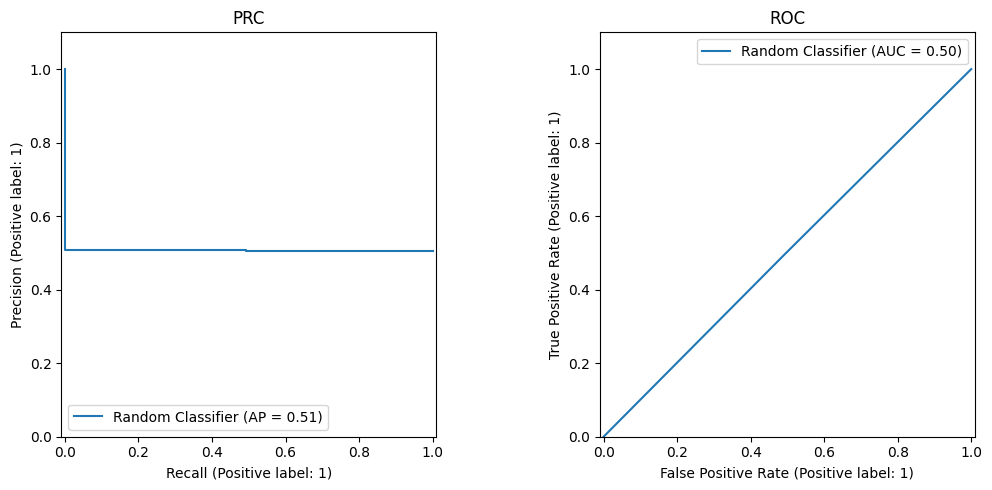

In [774]:
depict_pr_roc(y_test, y_random, 'Random Classifier')

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [775]:
from sklearn.linear_model import LogisticRegression

In [776]:
param_grid = {'C': np.logspace(-3, 5, 7)} 
mod = LogisticRegression()
grid_search = GridSearchCV(estimator=mod, param_grid=param_grid, scoring='average_precision', cv=5)
grid_search.fit(X_train, y_train)
best_C_log = grid_search.best_params_['C']
print(f"Лучший параметр C: {best_C_log}")

Logreg_model = LogisticRegression(max_iter = 1000000, C = best_C_log, penalty = 'l2')
Logreg_model.fit(X_train, y_train)
y_pred_proba_log = Logreg_model.decision_function(X_test)

y_random = np.random.randint(0, 2, size=y_test.shape)
df_metrics_log = pd.DataFrame(columns=['auc_pr', 'roc_auc_score', 'reg_const'])
df_metrics_log.loc['Logistic Regression'] = [
    average_precision_score(y_test, y_pred_proba_log),
    roc_auc_score(y_test, y_pred_proba_log),
    best_C,
]

df_metrics_log

Лучший параметр C: 0.001


,auc_pr,roc_auc_score,reg_const
Logistic Regression,0.833757,0.845335,27.825594


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

SVC with Linear Kernel metrics
AUC-PR: 0.8338
AUC-ROC: 0.8453


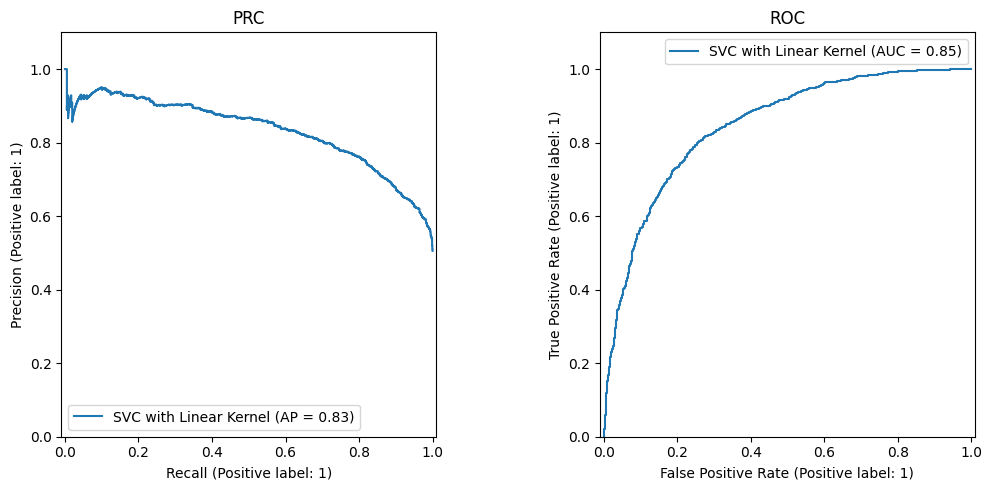

In [777]:
depict_pr_roc(y_test, y_pred_proba_log, classifier_name='SVC with Linear Kernel')

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



Linear SVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476
Random Classifier metrics
AUC-PR: 0.5180
AUC-ROC: 0.5236
Logistic Regression metrics
AUC-PR: 0.8338
AUC-ROC: 0.8453


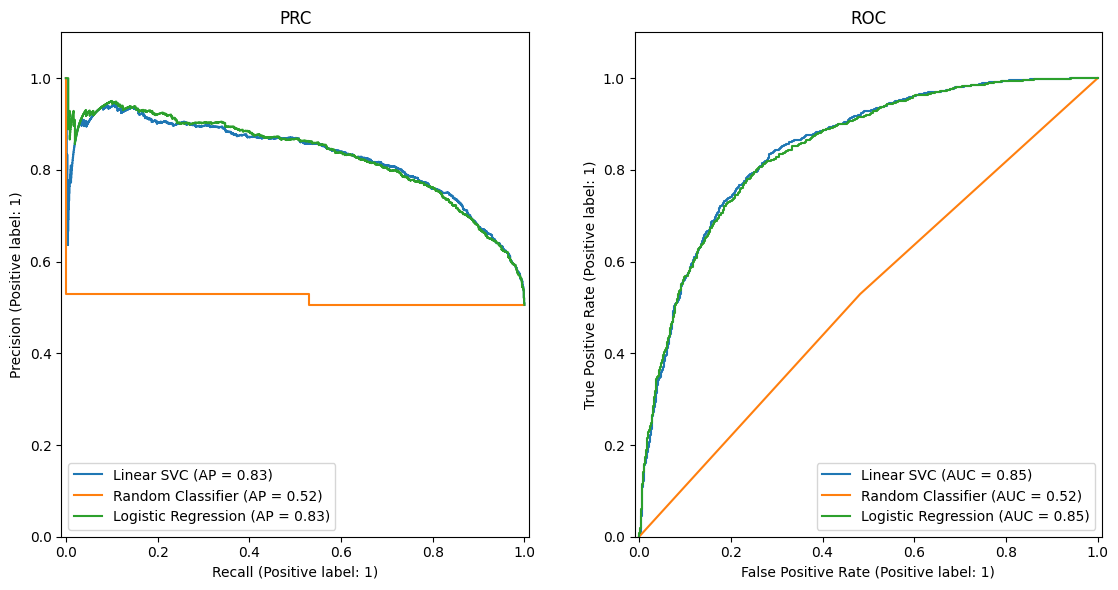

In [778]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
depict_pr_roc(y_test, y_pred_proba, 'Linear SVC', ax)
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, y_pred_proba_log, 'Logistic Regression', ax)

**Ответ:** В целом на этих данных модели ведут себя очень похожим образом, метрики качества незначительно отличаются. 

Однако можно заметить, что по метрике AUC-PR логические регрессия демонстрирует лучший результат, то есть она более эффективна в предсказании положительных классов в  сравнении с SVM, в терминах этой метрики LR лучше справляется с балансом между точностью и полнотой

С другой стороны, метрика AUC-ROC чуть лучше у SVM, то есть он лучше справляется с задачей различимости классов на порогах, то есть этот метод более эффективно делит выборку на + и - классы


#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [779]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [780]:
X_new, y_new =  make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                           random_state=42)

model = SVC(kernel='linear', probability=True)
model.fit(X_new, y_new)

SVC(kernel='linear', probability=True)

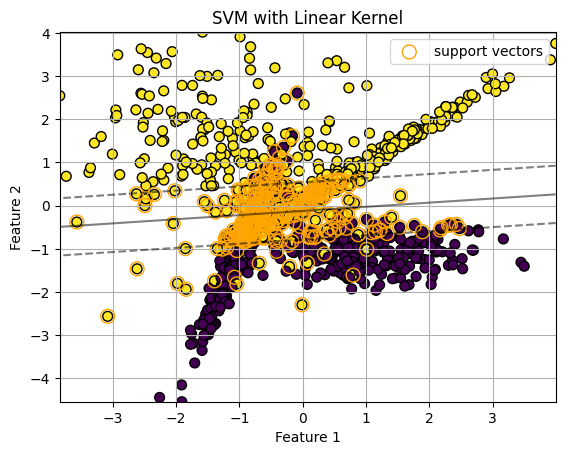

In [781]:
def plot_svm_2D(X, y, model,  plot_support=True):

    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', s=50)

    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="orange",
            facecolors='none'
        )

    plt.title("SVM with Linear Kernel")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.show()


plot_svm_2D(X_new, y_new, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опортные объекты - такие, которые находятся ближе всего к разделяющей гиперплоскости, а такде определяют её положение (гиперплоскости)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

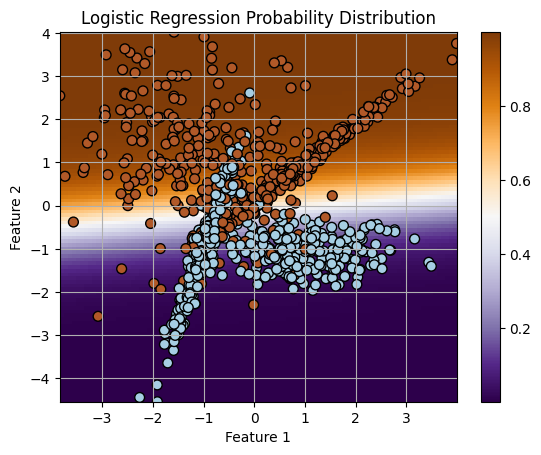

In [782]:
def plot_logreg_2D(X, y, model):

    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )
    
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=y, 
        cmap=plt.cm.Paired, 
        edgecolors='k', 
        s=50
    )

    plt.colorbar(image)
    plt.title("Logistic Regression Probability Distribution")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid()
    plt.show()


plot_logreg_2D(X_new, y_new, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** На графике область неуверенности - это переходная зона между цветами (фактически, это зона белого цвета). Цветовая карта отображает вероятности попадания в положительный класс (через функцию логической регрессии), соотвественно, зона, где модель будет неуверена (то есть как раз при вероятностях около значения 0.5), будет представлять из себя некоторую зону, разделяющую уверенный положительный класс и уверенный отрицтельный класс. 

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [783]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) #ошибка была тут, очев как счиать середину отрезка
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #ну и тут среднее надо взять
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios,  label='Калибровочная кривая')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
    plt.xlabel('Предсказанные вероятности')
    plt.ylabel('Фактические вероятности')
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.legend()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [784]:
X2, y2 = make_classification(n_samples=10000, n_features=2, n_redundant=0, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)

In [785]:
model = GridSearchCV(estimator=LinearSVC(dual='auto', max_iter=100000), param_grid={'C':np.logspace(-3, 3, 20)}, cv=5, scoring='average_precision')
model.fit(X_train2, y_train2)
C_4 = model.best_params_['C']
model = LinearSVC(C=C_4, dual='auto', max_iter=100000)
model.fit(X_train2, y_train2)
svm_preds = 1 /(1+np.exp(-model.decision_function(X_test2)))

model_lg = GridSearchCV(estimator=LogisticRegression(max_iter=100000), param_grid={'C':np.logspace(-3, 3, 20)}, cv=5, scoring='average_precision')
model_lg.fit(X_train2, y_train2)
C_5 = model_lg.best_params_['C']
model_lg = LogisticRegression(C=C_5, max_iter=100000)
model_lg.fit(X_train2, y_train2)
log_reg_preds = model_lg.predict_proba(X_test2)[:, 1]

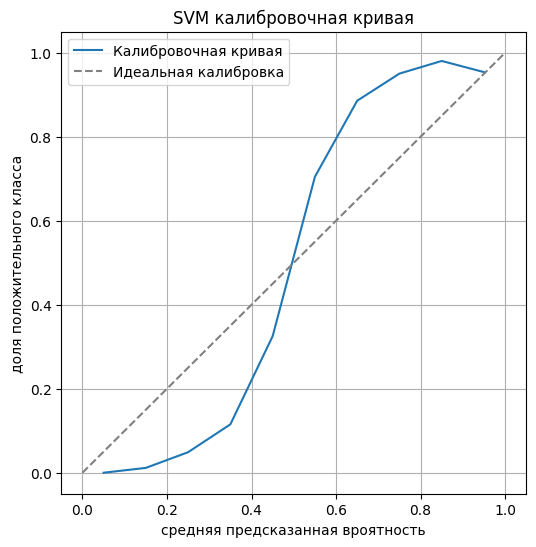

In [786]:
plot_calibration_curve(y_test2, svm_preds)
plt.title('SVM калибровочная кривая')
plt.xlabel('средняя предсказанная вроятность')
plt.ylabel('доля положительного класса')
plt.show()

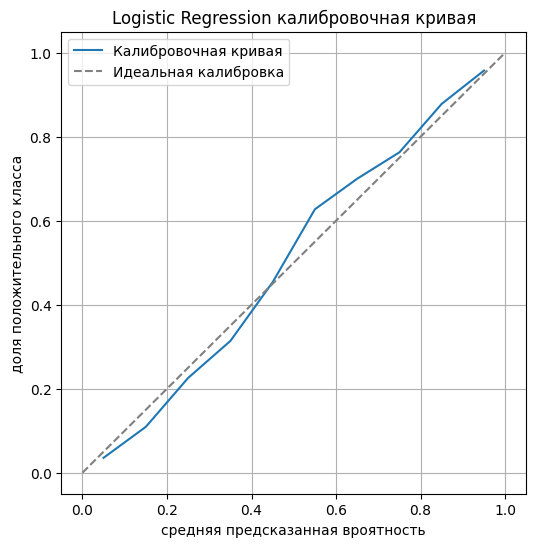

In [787]:
plot_calibration_curve(y_test2, log_reg_preds)
plt.title('Logistic Regression калибровочная кривая')
plt.xlabel('средняя предсказанная вроятность')
plt.ylabel('доля положительного класса')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Логистическая регресси хорошо откаллибрована, а вот SVM не очень.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [788]:
y_pred = np.clip(svm_preds, 1e-15, 1 - 1e-15)
logloss_value = -np.mean(y_test2 * np.log(y_pred) + (1 - y_test2) * np.log(1 - y_pred))

brier_score_value = np.mean((svm_preds - y_test2) ** 2)

print(f'Log Loss: {logloss_value:.4f}')
print(f'Brier Score: {brier_score_value:.4f}')

Log Loss: 0.4050
Brier Score: 0.1209


In [789]:
y_pred = np.clip(log_reg_preds, 1e-15, 1 - 1e-15)
logloss_value = -np.mean(y_test2 * np.log(y_pred) + (1 - y_test2) * np.log(1 - y_pred))

brier_score_value = np.mean((log_reg_preds - y_test2) ** 2)

print(f'Log Loss: {logloss_value:.4f}')
print(f'Brier Score: {brier_score_value:.4f}')

Log Loss: 0.2998
Brier Score: 0.0880


Изучите распределение ответов классификаторов при помощи гистограмм

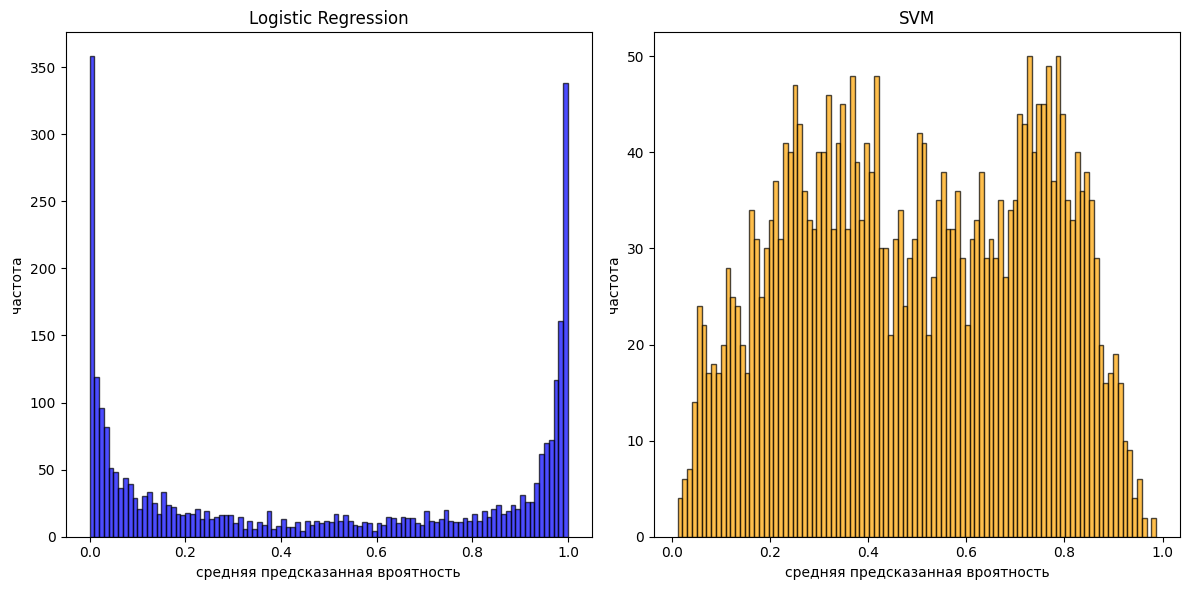

In [790]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(log_reg_preds, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title('Logistic Regression')
plt.xlabel('средняя предсказанная вроятность')
plt.ylabel('частота')

plt.subplot(1, 2, 2)
plt.hist(svm_preds, bins=100, alpha=0.7, color='orange', edgecolor='black')
plt.title('SVM')
plt.xlabel('средняя предсказанная вроятность')
plt.ylabel('частота')

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** КАК можно заметить, логистическая регрессия более уверена в своих предсказаниях, поскольку наибольшая плотность вероятностей сосредоточена на краях, в отличие от нее, SVM часто проявляет неопределенность для большинства объектов, что отражается в характере его распределения

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [791]:
from sklearn.calibration import CalibratedClassifierCV

In [792]:
model = GridSearchCV(estimator=LinearSVC(dual='auto', max_iter=100000), param_grid={'C': np.logspace(-3, 3, 20)}, cv=5, scoring='average_precision')
model.fit(X_train2, y_train2)
C_6 = model.best_params_['C']
svm = LinearSVC(C=C_6, dual='auto', max_iter=100000)
svm.fit(X_train2, y_train2)
calibrated_svm = CalibratedClassifierCV(estimator=svm, method='sigmoid', cv='prefit')
calibrated_svm.fit(X_train2, y_train2)
calibrated_svm_preds = calibrated_svm.predict_proba(X_test2)[:, 1]

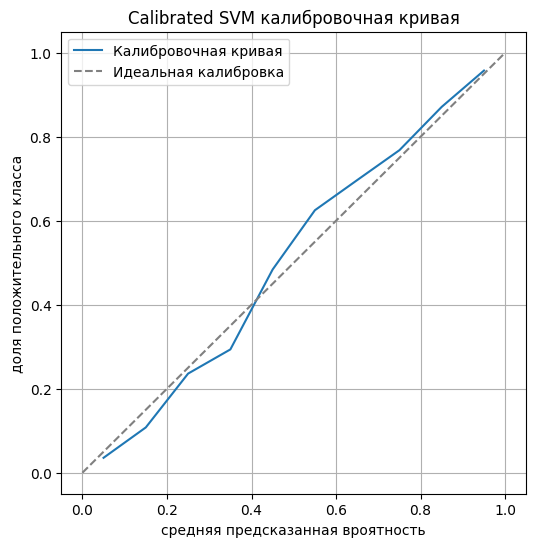

In [793]:
plot_calibration_curve(y_test2, calibrated_svm_preds)
plt.title('Calibrated SVM калибровочная кривая')
plt.xlabel('средняя предсказанная вроятность')
plt.ylabel('доля положительного класса')
plt.show()

In [794]:
y_pred = np.clip(calibrated_svm_preds, 1e-15, 1 - 1e-15)
logloss_value = -np.mean(y_test2 * np.log(y_pred) + (1 - y_test2) * np.log(1 - y_pred))

brier_score_value = np.mean((calibrated_svm_preds - y_test2) ** 2)

print(f'Log Loss: {logloss_value:.4f}')
print(f'Brier Score: {brier_score_value:.4f}')

Log Loss: 0.3002
Brier Score: 0.0880


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Калибровочная кривая и метерики улучшились после каллибровки вероятностей. действительно тонко.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [795]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [796]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [797]:
from sklearn.model_selection import train_test_split

In [798]:
data = pd.read_csv(path)

In [799]:
data

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,NaN,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [800]:
categorical_columns =  data.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col != 'Purchased Bike']
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

/var/folders/c1/2f76vwg555g_fgmfcx7m_j2w0000gn/T/ipykernel_90402/3342761755.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


In [801]:
X = data.drop('Purchased Bike', axis=1)
y = data['Purchased Bike']
y = y.map({'No': 0, 'Yes': 1})

In [802]:
X_numerical = X.select_dtypes(include=['int64', 'float64'])
X_categorical = X.select_dtypes(include=['object'])

В начале поработаем только с категориальными признаками

In [803]:
X_categorical.columns

Index(['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region'],
      dtype='object')

In [804]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [805]:
import time
from sklearn.preprocessing import OrdinalEncoder

In [806]:
start_time = time.time()
encoder = OrdinalEncoder()
X_encoded_train = encoder.fit_transform(X_train2)
X_encoded_test = encoder.fit_transform(X_test2)
model = LogisticRegression()
model.fit(X_encoded_train, y_train2)
end_time = time.time()

y_scores_cat = model.predict_proba(X_encoded_test)[:, 1]
auc_pr_ord_hot = average_precision_score(y_test2, y_scores_cat)

print(f"Общее время обучения модели: {end_time - start_time:.4f} секунд")
print(f"AUC-PR: {auc_pr_ord_hot:.4f}")

Общее время обучения модели: 0.0049 секунд
AUC-PR: 0.5959


Логистическая регресси с ordinary encoder metrics
AUC-PR: 0.5959
AUC-ROC: 0.6016


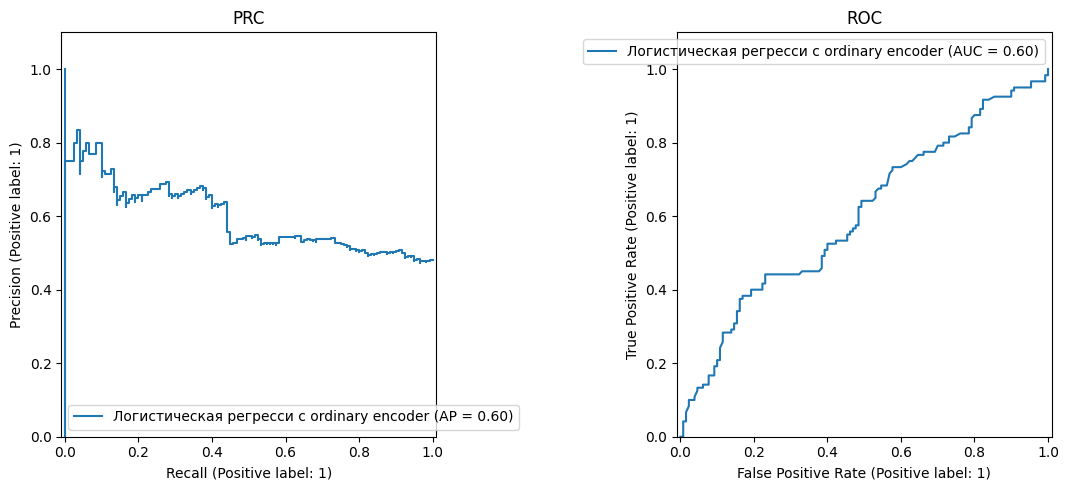

In [807]:
depict_pr_roc(y_test2, y_scores_cat, classifier_name='Логистическая регресси с ordinary encoder')

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [808]:
start_encoding_time = time.time()
X_encoded_train_ohe = pd.get_dummies(X_train2, columns=categorical_columns, drop_first=True)
X_encoded_test_ohe = pd.get_dummies(X_test2, columns=categorical_columns, drop_first=True)
end_encoding_time = time.time()

# param_grid = {'C': np.logspace(-10, 10, 7)} 
# mod = LogisticRegression()
# grid_search = GridSearchCV(estimator=mod, param_grid=param_grid, scoring='average_precision', cv=5)
# grid_search.fit(X_encoded_train_ohe, y_train2)
# best_C_log = grid_search.best_params_['C']
# print(best_C_log)

model = LogisticRegression(max_iter=10000, penalty = 'l2', random_state=32, C = 2154.4346900318865)
start_training_time = time.time()
model.fit(X_encoded_train_ohe, y_train2)
end_training_time = time.time()

y_scores_ohe = model.predict_proba(X_encoded_test_ohe)[:, 1]
auc_pr_one_hot = average_precision_score(y_test2, y_scores_ohe)

total_encoding_time = end_encoding_time - start_encoding_time
total_training_time = end_training_time - start_training_time

print(f"Время кодирования категориальных признаков: {total_encoding_time:.4f} секунд")
print(f"Время обучения модели: {total_training_time:.4f} секунд")
print(f"Время общее: {total_training_time + total_encoding_time:.4f} секунд")
print(f"AUC-PR: {auc_pr_one_hot:.4f}")

Время кодирования категориальных признаков: 0.0062 секунд
Время обучения модели: 0.0210 секунд
Время общее: 0.0272 секунд
AUC-PR: 0.6705


Логистическая регрессия с one-hot encoder metrics
AUC-PR: 0.6705
AUC-ROC: 0.6845


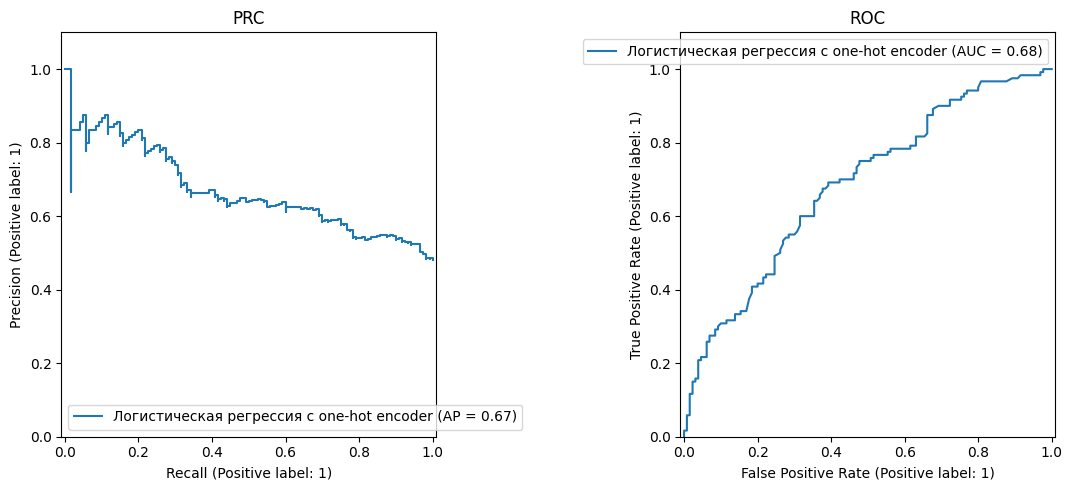

In [809]:
depict_pr_roc(y_test2, y_scores_ohe, classifier_name='Логистическая регрессия с one-hot encoder')

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [810]:
X_train_mte, X_test_mte, y_train_mte, y_test_mte = X_train2.copy(), X_test2.copy(), y_train2.copy(), y_test2.copy()

In [811]:
start_encoding_time = time.time()

for col in categorical_columns:
    column_dict = {}
    for category in X_train_mte[col].unique():
        column_dict[category] = ((X_train_mte[col] == category) & (y_train_mte == 1)).sum() / ((X_train_mte[col] == category).sum() + 1)
    
    X_train_mte[col] = X_train_mte[col].map(column_dict)
    X_test_mte[col] = X_test_mte[col].map(column_dict)
        
end_encoding_time = time.time()


# param_grid = {'C': np.logspace(-10, 10, 7)} 
# mod = LogisticRegression()
# grid_search = GridSearchCV(estimator=mod, param_grid=param_grid, scoring='average_precision', cv=5)
# grid_search.fit(X_train_mte, y_train_mte)
# best_C_log = grid_search.best_params_['C']
# print(best_C_log)

model = LogisticRegression(max_iter=1000, penalty = 'l2', random_state=32, C = 1)
start_training_time = time.time()
model.fit(X_train_mte, y_train_mte)
end_training_time = time.time()

y_scores_mte = model.predict_proba(X_test_mte)[:, 1]
auc_pr = average_precision_score(y_test_mte, y_scores_mte)

total_encoding_time = end_encoding_time - start_encoding_time
total_training_time = end_training_time - start_training_time

print(f"Время кодирования категориальных признаков: {total_encoding_time:.4f} секунд")
print(f"Время обучения модели: {total_training_time:.4f} секунд")
print(f"Общее время: {total_training_time + total_encoding_time:.4f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")

Время кодирования категориальных признаков: 0.0083 секунд
Время обучения модели: 0.0026 секунд
Общее время: 0.0108 секунд
AUC-PR: 0.6846


Логистическая регрессия с mean-target metrics
AUC-PR: 0.6846
AUC-ROC: 0.6804


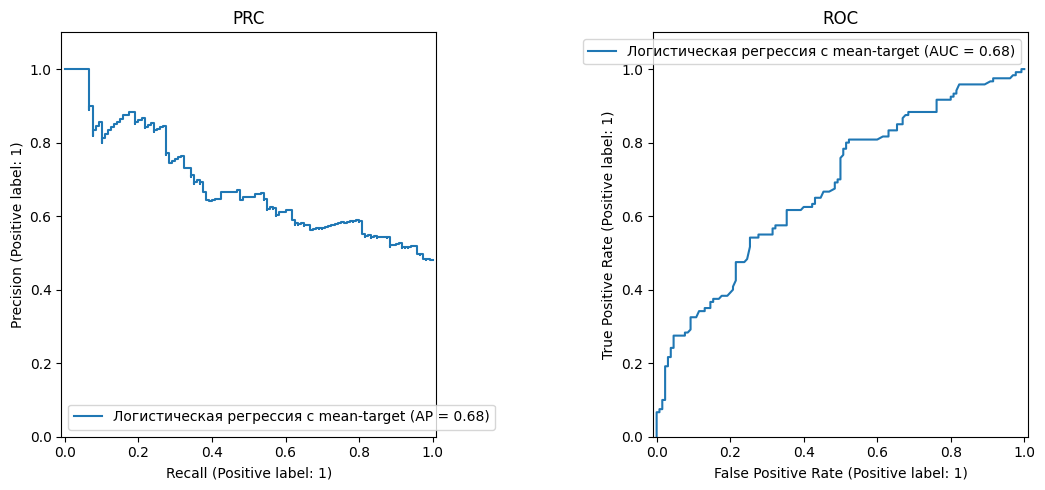

In [812]:
depict_pr_roc(y_test_mte, y_scores_mte, classifier_name='Логистическая регрессия с mean-target')

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [813]:
from sklearn.base import BaseEstimator, TransformerMixin

In [814]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols, noise_level=0):
        self.categorical_cols = categorical_cols
        self.noise_level = noise_level
        self.mean_target_mapping = {}

    def fit(self, X, y):
        for col in self.categorical_cols:
            column_dict = {}
            
            for category in X[col].unique():
                mean_target = ((X[col] == category) & (y == 1)).sum() / ((X[col] == category).sum())
                column_dict[category] = mean_target

            if self.noise_level > 0:
                noise = np.random.normal(0, self.noise_level, size=len(column_dict))
                column_dict = {k: v + n for k, v, n in zip(column_dict.keys(), column_dict.values(), noise)}
            self.mean_target_mapping[col] = column_dict
        
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.categorical_cols:
            X_transformed[col] = X_transformed[col].map(self.mean_target_mapping[col]).fillna(0)
        
        return X_transformed

In [815]:
encoder = MeanTargetEncoder(categorical_cols=X_train2.columns, noise_level=0)
encoder.fit(X_train2, y_train2)

X_train_encoded = encoder.transform(X_train2)
X_test_encoded = encoder.transform(X_test2)

model = LogisticRegression(max_iter=1000, penalty = 'l2', random_state=32, C = 1)
start_training_time = time.time()
model.fit(X_train_encoded, y_train2)
end_training_time = time.time()

y_scores_enc = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test2, y_scores_enc)

total_encoding_time = end_encoding_time - start_encoding_time
total_training_time = end_training_time - start_training_time

print(f"Время кодирования категориальных признаков: {total_encoding_time:.4f} секунд")
print(f"Время обучения модели: {total_training_time:.4f} секунд")
print(f"Общее время: {total_training_time + total_encoding_time:.4f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")

Время кодирования категориальных признаков: 0.0083 секунд
Время обучения модели: 0.0023 секунд
Общее время: 0.0106 секунд
AUC-PR: 0.6831


Логистическая регрессия с mean-target metrics
AUC-PR: 0.6831
AUC-ROC: 0.6798


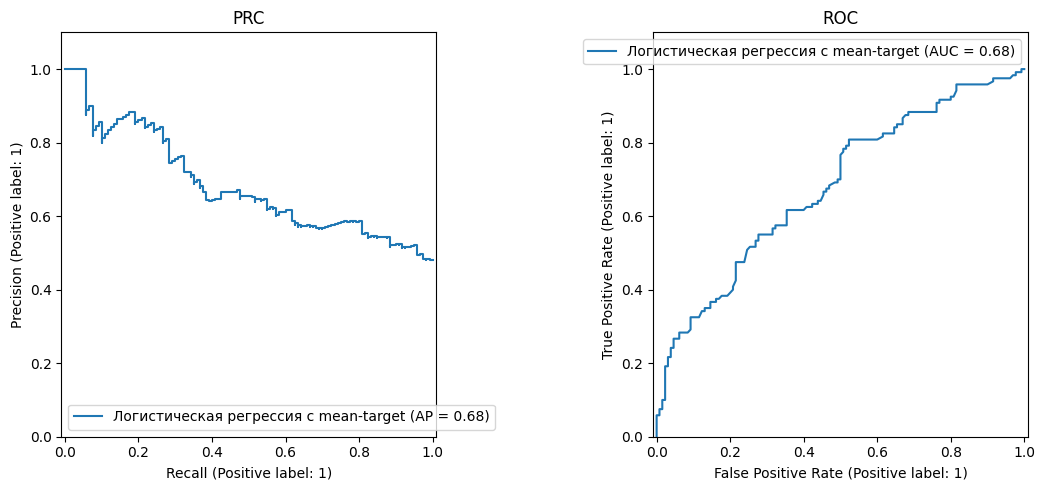

In [816]:
depict_pr_roc(y_test2, y_scores_enc, classifier_name='Логистическая регрессия с mean-target')

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [817]:
np.random.seed(52)
encoder = MeanTargetEncoder(categorical_cols=X_train2.columns, noise_level=0.001)
encoder.fit(X_train2, y_train2)

X_train_encoded6 = encoder.transform(X_train2)
X_test_encoded6 = encoder.transform(X_test2)

model = LogisticRegression(max_iter=1000, penalty = 'l2', C = 1)
start_training_time = time.time()
model.fit(X_train_encoded6, y_train2)
end_training_time = time.time()

y_scores_enc6 = model.predict_proba(X_test_encoded6)[:, 1]
auc_pr = average_precision_score(y_test2, y_scores_enc6)

total_encoding_time = end_encoding_time - start_encoding_time
total_training_time = end_training_time - start_training_time

print(f"Время кодирования категориальных признаков: {total_encoding_time:.4f} секунд")
print(f"Время обучения модели: {total_training_time:.4f} секунд")
print(f"Общее время: {total_training_time + total_encoding_time:.4f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")

Время кодирования категориальных признаков: 0.0083 секунд
Время обучения модели: 0.0023 секунд
Общее время: 0.0106 секунд
AUC-PR: 0.6832


Логистическая регрессия с mean-target metrics
AUC-PR: 0.6832
AUC-ROC: 0.6807


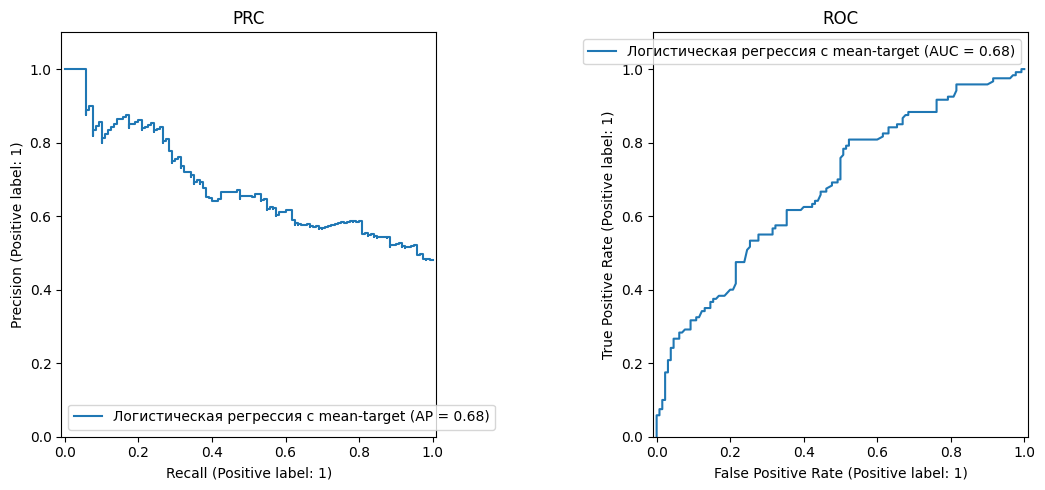

In [818]:
depict_pr_roc(y_test2, y_scores_enc6, classifier_name='Логистическая регрессия с mean-target')

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** В сравнении с предыдущим пунктом (в частности, бонусом) метрики улучшились посде добавления шума, такой метод помогает бороться с переобучением, так что предикты не сильно подгоняются под данные моделью

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [819]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global\_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global\_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [820]:
class MeanTargetEncoderNew(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols, noise_level=0, const=1):
        self.categorical_cols = categorical_cols
        self.noise_level = noise_level
        self.mean_target_mapping = {}
        self.const = const

    def fit(self, X, y):
        for col in self.categorical_cols:
            column_dict = {}
            
            for category in X[col].unique():
                mean_target = (((X[col] == category) & (y == 1)).sum() + self.const * np.mean(y)) / ((X[col] == category).sum() + self.const)
                column_dict[category] = mean_target

            if self.noise_level > 0:
                noise = np.random.normal(0, self.noise_level, size=len(column_dict))
                column_dict = {k: v + n for k, v, n in zip(column_dict.keys(), column_dict.values(), noise)}
            self.mean_target_mapping[col] = column_dict
        
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.categorical_cols:
            X_transformed[col] = X_transformed[col].map(self.mean_target_mapping[col]).fillna(0)
        
        return X_transformed

In [821]:
np.random.seed(52)
start_time = time.time()
best_score = -1
best_C = -1

for con in np.logspace(-3, 5, 10):
    encoder = MeanTargetEncoderNew(categorical_cols=X_train2.columns, noise_level=0.001, const = con)
    encoder.fit(X_train2, y_train2)

    X_train_encoded6 = encoder.transform(X_train2)
    X_test_encoded6 = encoder.transform(X_test2)

    model = LogisticRegression(max_iter=1000, penalty = 'l2', C = 1)
    start_training_time = time.time()
    model.fit(X_train_encoded6, y_train2)
    end_training_time = time.time()

    y_scores_enc6 = model.predict_proba(X_test_encoded6)[:, 1]
    auc_pr = average_precision_score(y_test2, y_scores_enc6)

    if best_score < auc_pr:
        best_score = auc_pr
        best_C = con

    total_encoding_time = end_encoding_time - start_encoding_time
    total_training_time = end_training_time - start_training_time

print(f"Время кодирования категориальных признаков: {total_encoding_time:.4f} секунд")
print(f"Время обучения модели: {total_training_time:.4f} секунд")
print(f"Общее время: {total_training_time + total_encoding_time:.4f} секунд")
print(f"AUC-PR: {best_score}, Best C: {best_C}")

Время кодирования категориальных признаков: 0.0083 секунд
Время обучения модели: 0.0008 секунд
Общее время: 0.0090 секунд
AUC-PR: 0.6836478771643957, Best C: 0.05994842503189409


Действительно лучше, чем OHE.

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [822]:
X_numerical = X_numerical.drop('ID', axis = 1)

Пропуски заполним средними (по ананлогии с тем, как делали с категориальными):

In [823]:
for c in X_numerical.columns:
    X_numerical[c].fillna(X_numerical[c].mean(), inplace=True)

/var/folders/c1/2f76vwg555g_fgmfcx7m_j2w0000gn/T/ipykernel_90402/3948918146.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_numerical[c].fillna(X_numerical[c].mean(), inplace=True)


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [824]:
for c in X_numerical.columns:
    print(f'у колонки с названием {c} число уникальных значений = {X_numerical[c].nunique()}')

у колонки с названием Income число уникальных значений = 17
у колонки с названием Children число уникальных значений = 7
у колонки с названием Cars число уникальных значений = 6
у колонки с названием Age число уникальных значений = 54


Лучше всего закодировать при помощи кодирования признаки Children, Cars и, вероятно, Income

In [825]:
X = pd.concat([X_numerical, X_categorical], axis = 1)

In [826]:
np.random.seed(52)
start_time = time.time()
best_score = -1
best_C = -1

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

for con in np.logspace(-3, 5, 10):
    encoder = MeanTargetEncoderNew(categorical_cols=X_train8.columns, noise_level=0.001, const = con)
    encoder.fit(X_train8, y_train8)

    X_train_encoded8 = encoder.transform(X_train8)
    X_test_encoded8 = encoder.transform(X_test8)

    model = LogisticRegression(max_iter=1000, penalty = 'l2', C = 1)
    start_training_time = time.time()
    model.fit(X_train_encoded8, y_train8)
    end_training_time = time.time()

    y_scores_enc8 = model.predict_proba(X_test_encoded8)[:, 1]
    auc_pr = average_precision_score(y_test8, y_scores_enc)

    if best_score < auc_pr:
        best_score = auc_pr
        best_C = con

end_time = time.time()
training_time = end_time - start_time

print(f"Общее время работы: {training_time:.4f} секунд")
print(f"AUC-PR: {best_score}, Best C: {best_C}")

Общее время работы: 0.1660 секунд
AUC-PR: 0.6831414507712124, Best C: 0.001


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

+:

-  счетчики дают меньшую разменость, чем OHE, а чем меньше признаков, тем мненее сложная будет модели + будем работать с менее разреженными матрицами в случае счетчиков, то есть точность будет выше

-  счетчики отражают информацию о частоте значений, что может добавлять дополнительные признаки, которые будут хорошо коррелировать с таргетом

-:

- вытекает из последнего плбса - могут предполагать не существующие линейные зависимости, что не всегда верно

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [827]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Python(92323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


--2024-11-30 02:18:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.4»

adult.data.4            [         <=>        ]   3,79M  1,68MB/s    за 2,3s    

2024-11-30 02:18:28 (1,68 MB/s) - «adult.data.4» сохранён [3974305]



In [828]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
22853,28,Private,410450,Bachelors,13,Divorced,Other-service,Unmarried,White,Female,0,0,48,England,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [829]:
X = df.drop(columns=['income'])
y = df['income'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [830]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [831]:
from sklearn.preprocessing import OneHotEncoder

In [832]:
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()
num_features = X_train_encoded.shape[1]
print(f"Количество новых признаков после One-Hot Encoding: {num_features}")

Количество новых признаков после One-Hot Encoding: 102


In [833]:
X_train = X_train[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_train_encoded))
X_test = X_test[numeric_features].reset_index().drop('index', axis=1).join(pd.DataFrame(X_test_encoded))
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [834]:
model = LogisticRegression(max_iter=1000, penalty = 'l2', C = 1)
model.fit(X_train, y_train)

y_scores = model.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_scores)

print(f"AUC-PR на тестовой выборке: {average_precision:.4f}")

AUC-PR на тестовой выборке: 0.7245


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [835]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=777, stratify=y_test)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [836]:
start_time = time.time()
X_train_40= X_train.iloc[:, model.coef_[0].argsort()[-40:]]
X_val_40 = X_val.iloc[:, model.coef_[0].argsort()[-40:]]

model = LogisticRegression(max_iter=10000, penalty = 'l2', C = 1)
model.fit(X_train_40, y_train)

y_val_scores = model.predict_proba(X_val_40)[:, 1]
average_precision = average_precision_score(y_val, y_val_scores)
end_time = time.time()

print(f"AUC-PR на валидационной выборке: {average_precision:.4f}")
print(f"Время работы : {end_time - start_time:.4f}")

AUC-PR на валидационной выборке: 0.7483
Время работы : 22.2905


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Изменилось ли качество? Как?

Качество несколько улучшлось (на 2 сотые)

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [837]:
from sklearn.preprocessing import StandardScaler

In [838]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=777, stratify=y_test)

In [839]:
scaler = StandardScaler()
encoder = OneHotEncoder()
np.random.seed(52)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train_ = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
X_val_ = np.concatenate((X_val_encoded, X_val_scaled), axis=1)
X_test_ = np.concatenate((X_test_encoded, X_test_scaled), axis=1)

model = LogisticRegression(max_iter=10000, penalty = 'l2', C = 40)
model.fit(X_train_, y_train)

y_val_scores = model.predict_proba(X_val_)[:, 1]
average_precision_val = average_precision_score(y_val, y_val_scores)
end_time = time.time()

y_test_scores = model.predict_proba(X_test_)[:, 1]
average_precision_test = average_precision_score(y_test, y_test_scores)
end_time = time.time()

print(f"AUC-PR на валидационной выборке: {average_precision_val:.4f}")
print(f"AUC-PR на тестовой выборке: {average_precision_test:.4f}")
print(f"Время работы : {end_time - start_time:.4f}")

AUC-PR на валидационной выборке: 0.7644
AUC-PR на тестовой выборке: 0.7715
Время работы : 22.7527


Еще немного улучшили модель (еще на 2 сотые) - уже очень круто

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [840]:
scaler = StandardScaler()
encoder = OneHotEncoder()
np.random.seed(52)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_features))
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoder.get_feature_names_out(categorical_features))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_features))

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=numeric_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_features)

X_train_ = pd.concat([X_train_encoded_df, X_train_scaled_df], axis=1)
X_val_ = pd.concat([X_val_encoded_df, X_val_scaled_df], axis=1)
X_test_ = pd.concat([X_test_encoded_df, X_test_scaled_df], axis=1)

X_train_40= X_train_.iloc[:, model.coef_[0].argsort()[-40:]]
X_val_40 = X_val_.iloc[:, model.coef_[0].argsort()[-40:]]
X_test_40 = X_test_.iloc[:, model.coef_[0].argsort()[-40:]]

model = LogisticRegression(max_iter=10000, penalty = 'l2', C = 40)
model.fit(X_train_40, y_train)

y_val_scores = model.predict_proba(X_val_40)[:, 1]
average_precision_val = average_precision_score(y_val, y_val_scores)
end_time = time.time()

y_test_scores = model.predict_proba(X_test_40)[:, 1]
average_precision_test = average_precision_score(y_test, y_test_scores)

print(f"AUC-PR на валидационной выборке: {average_precision_val:.4f}")
print(f"AUC-PR на тестовой выборке: {average_precision_test:.4f}")
print(f"Время работы : {end_time - start_time:.4f}")

AUC-PR на валидационной выборке: 0.7626
AUC-PR на тестовой выборке: 0.7670
Время работы : 22.9420


В целом, получили результат получше, чем перваначальный способ, метрик близки по значениям, можно утверждать, что качество улучшилось.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [841]:
np.random.seed(52)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train_ = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
X_val_ = np.concatenate((X_val_encoded, X_val_scaled), axis=1)
X_test_ = np.concatenate((X_test_encoded, X_test_scaled), axis=1)

encoded_feature_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate((encoded_feature_names, numeric_features))

X_train_df = pd.DataFrame(X_train_, columns=all_feature_names)

correlation = X_train_df.corrwith(y_train)

top_features = correlation.abs().nlargest(40).index
X_train_filtered = X_train_df[top_features]
X_val_filtered = pd.DataFrame(X_val_, columns=all_feature_names)[top_features]
X_test_filtered = pd.DataFrame(X_test_, columns=all_feature_names)[top_features]

start_time = time.time()
model = LogisticRegression(max_iter=10000, penalty='l2', C=1)
model.fit(X_train_filtered, y_train)

y_val_scores = model.predict_proba(X_val_filtered)[:, 1]
average_precision_val = average_precision_score(y_val, y_val_scores)
end_time = time.time()

y_test_scores = model.predict_proba(X_test_filtered)[:, 1]
average_precision_test = average_precision_score(y_test, y_test_scores)

print(f"AUC-PR на валидационной выборке: {average_precision_val:.4f}")
print(f"AUC-PR на тестовой выборке: {average_precision_test:.4f}")
print(f"Время работы : {end_time - start_time:.4f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


AUC-PR на валидационной выборке: 0.6534
AUC-PR на тестовой выборке: 0.6410
Время работы : 0.1915


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [842]:
np.random.seed(52)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train_ = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
X_val_ = np.concatenate((X_val_encoded, X_val_scaled), axis=1)
X_test_ = np.concatenate((X_test_encoded, X_test_scaled), axis=1)

encoded_feature_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate((encoded_feature_names, numeric_features))

X_train_df = pd.DataFrame(X_train_, columns=all_feature_names)
X_val_df = pd.DataFrame(X_val_, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_, columns=all_feature_names)

def calculate_t_statistic(d):
    t_stats = {}
    c = [col for col in d.columns if col != 'income']
    for column in c:

        group1 = d[d['income'] == 1][column]
        group0 = d[d['income'] == 0][column]
        
        n1 = len(group1)
        n0 = len(group0)
        mu1 = group1.mean()
        mu0 = group0.mean()
        sigma1 = group1.std(ddof=1)
        sigma0 = group0.std(ddof=1)
        
        t_stat = abs(mu1 - mu0) / np.sqrt((n1 * sigma1**2 + n0 * sigma0**2) / (n1 + n0))
        t_stats[column] = t_stat
    return t_stats

start_time = time.time()
df_temp = pd.concat([X_train_df, y_train], axis = 1)
t_statistics = calculate_t_statistic(df_temp)

top_40_features_t = sorted(t_statistics.items(), key=lambda x: x[1], reverse=True)[:40]
top_40_features_t = [feature for feature, _ in top_40_features_t]

/var/folders/c1/2f76vwg555g_fgmfcx7m_j2w0000gn/T/ipykernel_90402/1577244926.py:37: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = abs(mu1 - mu0) / np.sqrt((n1 * sigma1**2 + n0 * sigma0**2) / (n1 + n0))


In [843]:
X_train_40best = X_train_df[top_40_features_t]
X_val_40best = X_val_df[top_40_features_t]
X_test_40best = X_test_df[top_40_features_t]
end_time = time.time()

model = LogisticRegression(max_iter = 100000, penalty = 'l2', C = 10)
model.fit(X_train_40best, y_train)

y_val_scores = model.predict_proba(X_val_40best)[:, 1]
average_precision_val = average_precision_score(y_val, y_val_scores)
end_time = time.time()

y_test_scores = model.predict_proba(X_test_40best)[:, 1]
average_precision_test = average_precision_score(y_test, y_test_scores)

print(f"AUC-PR на валидационной выборке: {average_precision_val:.4f}")
print(f"AUC-PR на тестовой выборке: {average_precision_test:.4f}")
print(f"Время работы отбора признаков: {end_time - start_time:.4f}")

AUC-PR на валидационной выборке: 0.6691
AUC-PR на тестовой выборке: 0.6540
Время работы отбора признаков: 0.5044


Работает довольно долго, качество получили не очень высокое.

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [844]:
np.random.seed(52)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train_ = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
X_val_ = np.concatenate((X_val_encoded, X_val_scaled), axis=1)
X_test_ = np.concatenate((X_test_encoded, X_test_scaled), axis=1)

encoded_feature_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate((encoded_feature_names, numeric_features))

X_train_df = pd.DataFrame(X_train_, columns=all_feature_names)
X_val_df = pd.DataFrame(X_val_, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_, columns=all_feature_names)

In [845]:
from tqdm import tqdm

In [846]:
start_time = time.time()
model_wrapp = LogisticRegression(max_iter=100000, penalty='l2', C=0.1)

F_i = X_train_df.columns.tolist()
k = 40
m = 5
epsilon = 0.01 

while len(F_i) > k:
    model_wrapp.fit(X_train_df[F_i], y_train)

    y_val_scores = model_wrapp.predict_proba(X_val_df[F_i])[:, 1]
    current_score = average_precision_score(y_val, y_val_scores)

    worst_scores = {}
    worst_columns = []

    for column in tqdm(F_i, desc="Evaluating columns", leave=False):
        F_i_less_f = [col for col in F_i if col != column]
        model_wrapp.fit(X_train_df[F_i_less_f], y_train)
        y_val_scores_less_f = model_wrapp.predict_proba(X_val_df[F_i_less_f])[:, 1]
        average_precision_val = average_precision_score(y_val, y_val_scores_less_f)

        if current_score < average_precision_val:
            worst_columns.append(column)
            worst_scores[column] = average_precision_val

    num_to_remove = min(m, len(worst_columns))
    for col in sorted(worst_columns, key=lambda x: worst_scores[x])[:num_to_remove]:
        F_i.remove(col)

model_wrapp.fit(X_train_df[F_i], y_train)
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Training Time: 185.0235812664032 seconds


In [847]:
final_y_test_scores = model_wrapp.predict_proba(X_test_df[F_i])[:, 1]
final_average_precision = average_precision_score(y_test, final_y_test_scores)
print("Final Average Precision on Test Set:", final_average_precision)

Final Average Precision on Test Set: 0.7700648956156178


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [848]:
np.random.seed(52)

X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_val_encoded = encoder.transform(X_val[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train_ = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
X_val_ = np.concatenate((X_val_encoded, X_val_scaled), axis=1)
X_test_ = np.concatenate((X_test_encoded, X_test_scaled), axis=1)

encoded_feature_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate((encoded_feature_names, numeric_features))

X_train_df = pd.DataFrame(X_train_, columns=all_feature_names)
X_val_df = pd.DataFrame(X_val_, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_, columns=all_feature_names)

In [849]:
start_time = time.time()
model_wrapp = LogisticRegression(max_iter=100000, penalty='l2', C=0.1)

F_i = []
all_features = X_train_df.columns.tolist()
k = 40
epsilon = 0.01 

while len(F_i) < k:
    
    best_score = -1
    best_feature = None
    
    for column in tqdm(all_features, desc="Evaluating columns", leave=False):

        if column in F_i:
            continue
    
        F_i_plus_f = F_i + [column]
        
        model_wrapp.fit(X_train_df[F_i_plus_f], y_train)
        y_val_scores_plus_f = model_wrapp.predict_proba(X_val_df[F_i_plus_f])[:, 1]
        average_precision_val = average_precision_score(y_val, y_val_scores_plus_f)

        if average_precision_val > best_score:
            best_score = average_precision_val
            best_feature = column


    if len(F_i) > 0:
        m = LogisticRegression(max_iter=100000, penalty='l2', C=0.1)
        m.fit(X_train_df[F_i], y_train)
        current_score = average_precision_score(y_val, m.predict_proba(X_val_df[F_i])[:, 1])
    else:
        current_score = -float('inf')
    

    if best_score > current_score + epsilon:
        F_i.append(best_feature)
    else:
        break

model_wrapp.fit(X_train_df[F_i], y_train)
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Training Time: 10.659126043319702 seconds


In [850]:
final_y_test_scores = model_wrapp.predict_proba(X_test_df[F_i])[:, 1]
final_average_precision = average_precision_score(y_test, final_y_test_scores)
print("Final Average Precision on Test Set:", final_average_precision)

Final Average Precision on Test Set: 0.729218246186865


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
Наилучшее качество было достигнуто с помощью третьего метода (жадный отбор признаков) при убирании признаков, он продемонстрировал наивысшие значения AUC-PR (0.7701). 
Первый метод также показал хорошие результаты, однако его вычислительная сложность и время обработки значительно выше. Второй метод оказался наименее эффективным по качеству модели и не смог достичь уровня первых двух методов. 

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [851]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [852]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [853]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [854]:
categorical_columns = ['job', 'marital', 'education', 'default', 
                       'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_columns = ['age', 'pdays', 'campaign', 'emp.var.rate', 'cons.price.idx', 
                   'cons.conf.idx', 'euribor3m', 'nr.employed']

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [855]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

kf = KFold(n_splits=5, shuffle=True, random_state=52)

In [856]:
df.sample()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
5036,50,blue-collar,married,basic.4y,no,no,no,telephone,may,wed,304,2,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no


Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [857]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

In [858]:
preds = {}

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter = 10000))
])

for i, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
    X_train = X.loc[train_i]
    y_train = y.loc[train_i]
    
    X_test = X.loc[test_i]
    y_test = y.loc[test_i]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[f'{i} fold'] = y_pred

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [859]:
incomes = []
costs = []
profits = []

for fold_index, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
    y_pred = preds[f'{fold_index} fold']
    y_test = y.loc[test_i].values
    
    income = 10 * np.sum((y_pred == 1) & (y_test == 1))
    cost = np.sum(y_pred)
    profit = income - cost
    
    incomes.append(income)
    costs.append(cost)
    profits.append(profit)

In [860]:
average_income = np.mean(incomes)
average_cost = np.mean(costs)
average_profit = np.mean(profits)

std_dev_profit = np.std(profits)

total_costs = np.sum(costs)
total_incomes = np.sum(incomes)
total_profits = np.sum(profits)
total_calls = np.sum([np.sum(y_pred) for y_pred in preds.values()])


print(f"Средняя выручка: {average_income}")
print(f"Стандартное отклонение прибыли: {std_dev_profit}")
print(f"Сколько денег придётся отдать операторам: {total_costs}")
print(f"Пропорциональна ли бизнес-метрика выбранной метрике классификации: {'Да' if average_profit > 0 else 'Нет'}")

Средняя выручка: 2114.0
Стандартное отклонение прибыли: 91.46496597058352
Сколько денег придётся отдать операторам: 1588
Пропорциональна ли бизнес-метрика выбранной метрике классификации: Да


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [861]:
incomes = []
costs = []
profits = []

for fold_index, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
    y_pred = preds[f'{fold_index} fold']
    y_test = y.loc[test_i].values
    successful_calls = (y_pred == 1) & (y_test == 1)
    
    income = np.sum(np.random.uniform(0, 20, np.sum(successful_calls)) * successful_calls[successful_calls])
    cost = np.sum(y_pred)
    profit = income - cost
    
    incomes.append(income)
    costs.append(cost)
    profits.append(profit)

In [862]:
average_income = np.mean(incomes)
average_cost = np.mean(costs)
average_profit = np.mean(profits)

std_dev_profit = np.std(profits)

total_costs = np.sum(costs)
total_incomes = np.sum(incomes)
total_profits = np.sum(profits)
total_calls = np.sum([np.sum(y_pred) for y_pred in preds.values()])


print(f"Средняя выручка: {average_income}")
print(f"Стандартное отклонение прибыли: {std_dev_profit}")
print(f"Сколько денег придётся отдать операторам: {total_costs}")
print(f"Пропорциональна ли бизнес-метрика выбранной метрике классификации: {'Да' if average_profit > 0 else 'Нет'}")

Средняя выручка: 2112.3097180105547
Стандартное отклонение прибыли: 161.75257960968221
Сколько денег придётся отдать операторам: 1588
Пропорциональна ли бизнес-метрика выбранной метрике классификации: Да


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

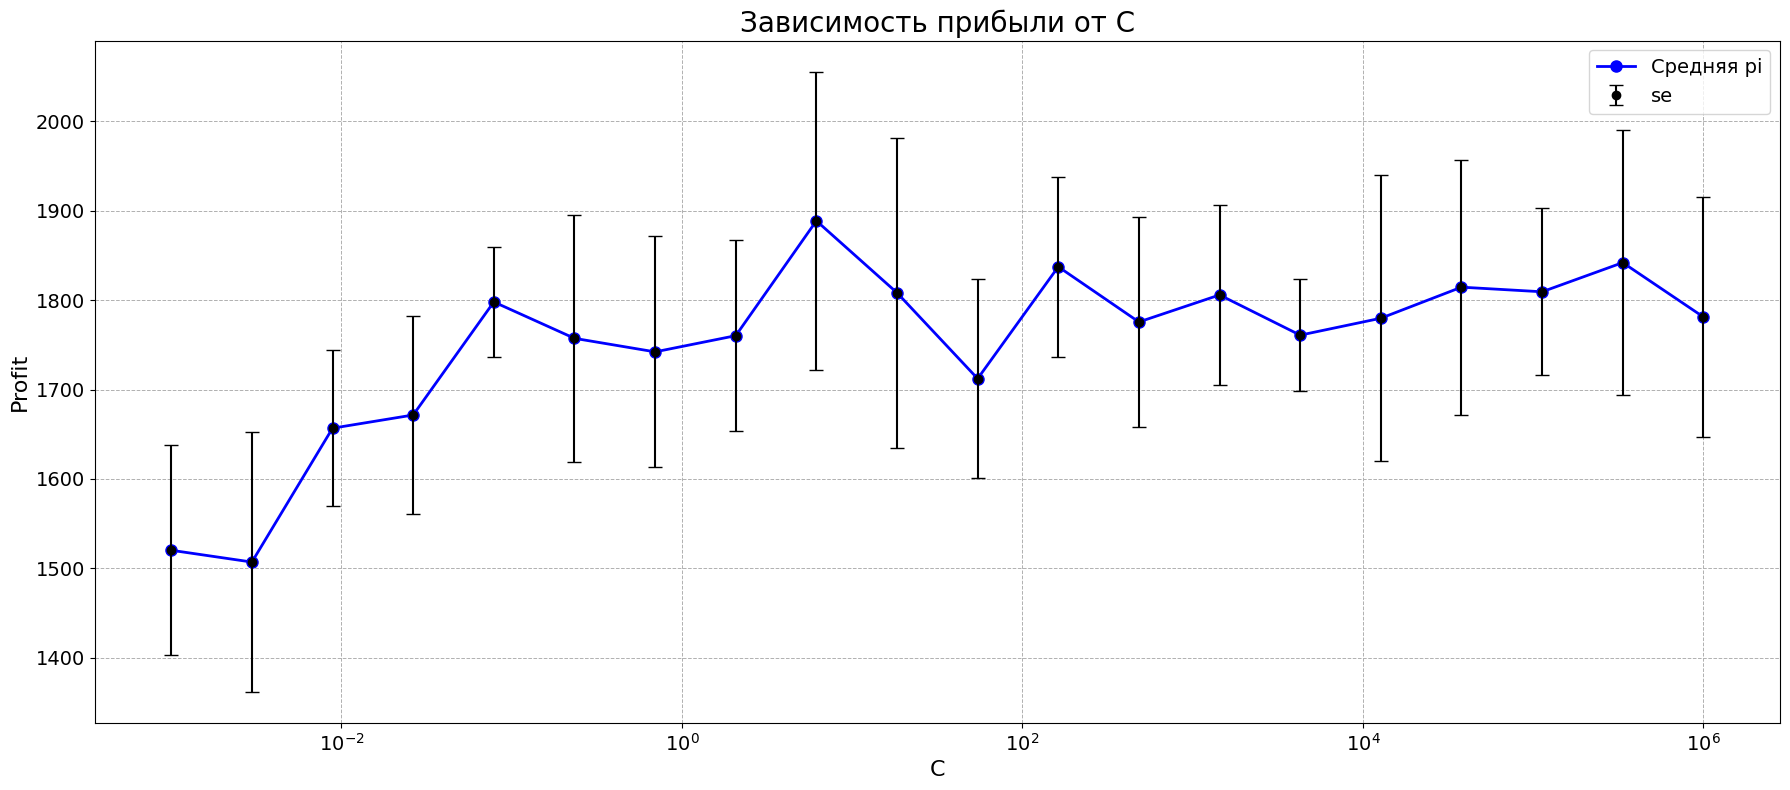

In [863]:
profits_mean  = []
profits_std  = []

for C in np.logspace(-3, 6, 20):
    preds_dict = {}
    
    column_transformer = ColumnTransformer([
      ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
      ('scaler', StandardScaler(), numeric_columns)])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(max_iter = 10000, C = C))])

    for i, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
        X_train = X.loc[train_i]
        y_train = y.loc[train_i]
          
        X_test = X.loc[test_i]
        y_test = y.loc[test_i]

        model = pipeline.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        preds[f'{i} fold'] = y_pred


    incomes = []
    costs = []
    profits = []

    for fold_index, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
        y_pred = preds[f'{fold_index} fold']
        y_test = y.loc[test_i].values
        successful_calls = (y_pred == 1) & (y_test == 1)
        
        income = np.sum(np.random.uniform(0, 20, np.sum(successful_calls)) * successful_calls[successful_calls])
        cost = np.sum(y_pred)
        profit = income - cost
        
        incomes.append(income)
        costs.append(cost)
        profits.append(profit)

    profits_mean.append(np.mean(profits))
    profits_std.append(np.std(profits))


C_values = np.logspace(-3, 6, 20)

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(C_values, profits_mean, marker='o', linestyle='-', color='b', markersize=8, linewidth=2, label='Средняя pi')
ax.errorbar(C_values, profits_mean, yerr=profits_std, fmt='o', color='k', capsize=5, label='se')

ax.set_xlabel('C', fontsize=16)
ax.set_ylabel('Profit', fontsize=16)
ax.set_title('Зависимость прибыли от C', fontsize=20)
ax.set_xscale('log')
ax.grid(True, which="both", linestyle='--', linewidth=0.7)
ax.legend(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

100%|██████████| 5/5 [00:59<00:00, 11.83s/it]


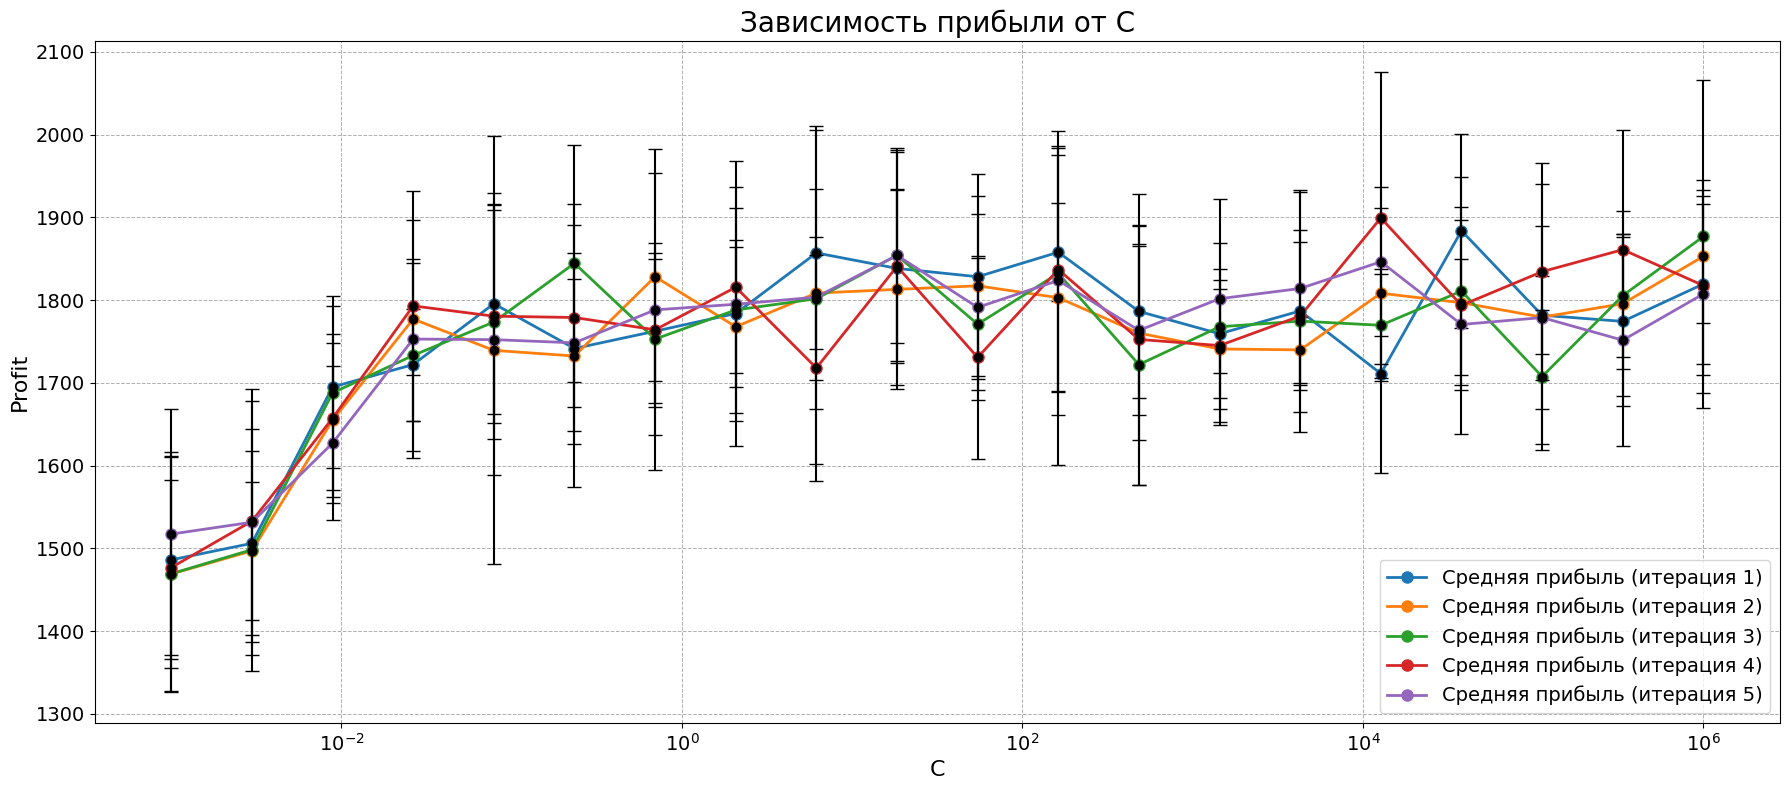

In [864]:
fig, ax = plt.subplots(1, figsize=(18, 8))
profits_mean_list = []
profits_std_list = []

for r in tqdm(range(5)):
    profits_mean  = []
    profits_std  = []

    for C in np.logspace(-3, 6, 20):
        preds_dict = {}
        
        column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
        ('scaler', StandardScaler(), numeric_columns)])

        pipeline = Pipeline(steps=[
            ('ohe_and_scaling', column_transformer),
            ('regression', LogisticRegression(max_iter = 10000, C = C))])

        for i, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
            X_train = X.loc[train_i]
            y_train = y.loc[train_i]
            
            X_test = X.loc[test_i]
            y_test = y.loc[test_i]

            model = pipeline.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            preds[f'{i} fold'] = y_pred


        incomes = []
        costs = []
        profits = []

        for fold_index, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
            y_pred = preds[f'{fold_index} fold']
            y_test = y.loc[test_i].values
            successful_calls = (y_pred == 1) & (y_test == 1)
            
            income = np.sum(np.random.uniform(0, 20, np.sum(successful_calls)) * successful_calls[successful_calls])
            cost = np.sum(y_pred)
            profit = income - cost
            
            incomes.append(income)
            costs.append(cost)
            profits.append(profit)

        profits_mean.append(np.mean(profits))
        profits_std.append(np.std(profits))
    
    profits_mean_list.append(profits_mean)
    profits_std_list.append(profits_std)


C_values = np.logspace(-3, 6, 20)

for r in range(5):
    ax.plot(C_values, profits_mean_list[r], marker='o', linestyle='-', markersize=8, linewidth=2,
            label=f'Средняя прибыль (итерация {r+1})')

    ax.errorbar(C_values, profits_mean_list[r], yerr=profits_std_list[r], fmt='o', color='k', capsize=5)

ax.set_xlabel('C', fontsize=16)
ax.set_ylabel('Profit', fontsize=16)
ax.set_title('Зависимость прибыли от C', fontsize=20)
ax.set_xscale('log')
ax.grid(True, which="both", linestyle='--', linewidth=0.7)
ax.legend(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

На значениях C, превышающих 1, особенно при  [10, 1000], наблюдаются наилучшие результаты по прибыли.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ 

Для бизнеса в условии задачи важен высокий recall модели, так как мы стремимся минимизировать пропуски потенциальных клиентов и важных событий, так как низкий recall может привести к упущенной прибыли и снижению конкурентоспособности. При этом precision тоже важен, мы предпочитаем охватывать больше целевых объектов, даже если это приводит к ложным срабатываниям

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [865]:
preds_dict = {}

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
  ])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter = 10000, C = 100))
  ])

i = 0

profits_t = {}
for threshold in tqdm(np.arange(0, 1, 0.01)):
    profits = []
    for fold_index, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
        X_train, y_train = X.loc[train_i], y.loc[train_i]
        X_test, y_test = X.loc[test_i], y.loc[test_i]
        model = pipeline.fit(X_train, y_train)
        preds_proba = model.predict_proba(X_test)

        y_pred = np.where(preds_proba[:, 1] > threshold, 1, 0)

        value = np.random.uniform(0, 20, len(y_pred[(y_pred == 1) & (y_test.values == 1)]))
        income = np.sum(value)
        cost = np.sum(y_pred)
        profit = income - cost
        profits.append(profit)

    profits_t[threshold] = {
        'mean': np.mean(profits),
        'std': np.std(profits)
    }

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


In [866]:
mean_values = []
std_values = []

for profit in profits_t.values():
    mean_values.append(profit['mean'])
    std_values.append(profit['std'])
    
best_threshold = max(profits_t, key=lambda threshold: profits_t[threshold]['mean'])
thresholds = list(profits_t.keys())

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




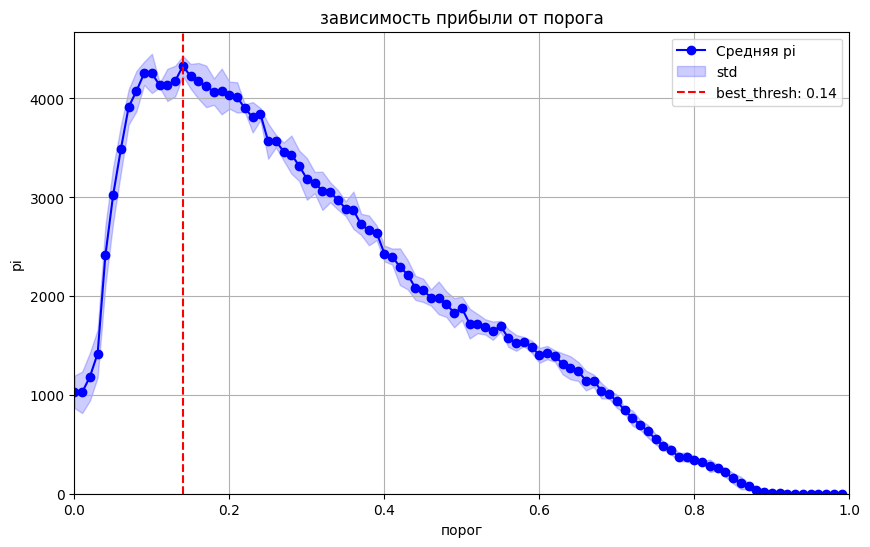

In [867]:
thresholds = list(profits_t.keys())
mean_values = [profit['mean'] for profit in profits_t.values()]
std_values = [profit['std'] for profit in profits_t.values()]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, mean_values, label='Средняя pi', color='blue', marker='o')
plt.fill_between(thresholds, 
                 np.array(mean_values) - np.array(std_values), 
                 np.array(mean_values) + np.array(std_values), 
                 color='blue', alpha=0.2, label='std')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'best_thresh: {best_threshold:.2f}')

plt.title('зависимость прибыли от порога')
plt.xlabel('порог')
plt.ylabel('pi')
plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ 

С увеличением порога прибыль возрастает, но потом по мере дальнейшего роста порога, прибыль снижается (точность падает, а полнота растет), а вообще мы считаем для для бизнеса важнее точнее, чем полнота. Однако стоит отметить, что полнота не может быть слишком низкой, поскольку, даже если мы редко совершаем ошибки, мы также обращаемся к ограниченному числу клиентов, поэтому лучше увеличить долю клиентов, которым мы звоним, даже если это приведет к небольшому снижению точности, поскольку в итоге это позволит повысить прибыль.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [868]:
from scipy import stats

In [869]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

profits_default = []
profits_optimized = []

for fold_index, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
    X_train, y_train = X.loc[train_i], y.loc[train_i]
    X_test, y_test = X.loc[test_i], y.loc[test_i]

    model = pipeline.fit(X_train, y_train)
    preds_proba = model.predict_proba(X_test)

    y_pred_default = np.where(preds_proba[:, 1] > threshold, 1, 0)
    value_default = np.random.uniform(0, 20, len(y_pred_default[(y_pred_default == 1) & (y_test.values == 1)]))
    income_default = np.sum(value_default)
    cost_default = np.sum(y_pred_default)
    profit_default = income_default - cost_default
    profits_default.append(profit_default)

for fold_index, (train_i, test_i) in enumerate(kf.split(X, y), start=1):
    X_train, y_train = X.loc[train_i], y.loc[train_i]
    X_test, y_test = X.loc[test_i], y.loc[test_i]

    model_optimized = pipeline.fit(X_train, y_train)
    preds_proba_optimized = model_optimized.predict_proba(X_test)

    y_pred_optimized = np.where(preds_proba_optimized[:, 1] > best_threshold, 1, 0)
    value_optimized = np.random.uniform(0, 20, len(y_pred_optimized[(y_pred_optimized == 1) & (y_test.values == 1)]))
    income_optimized = np.sum(value_optimized)
    cost_optimized = np.sum(y_pred_optimized)
    profit_optimized = income_optimized - cost_optimized
    profits_optimized.append(profit_optimized)


t_statistic, p_value = stats.ttest_rel(profits_default, profits_optimized)
mean_profit_default = np.mean(profits_default)
std_profit_default = np.std(profits_default)

mean_profit_optimized = np.mean(profits_optimized)
std_profit_optimized = np.std(profits_optimized)

print(f"Средняя прибыль дефолтной модели: {mean_profit_default:.2f} ± {std_profit_default:.2f}")
print(f"Средняя прибыль оптимизированной модели: {mean_profit_optimized:.2f} ± {std_profit_optimized:.2f}")
print(f"t-статистика: {t_statistic:.4f}, p-значение: {p_value:.4f}")

Средняя прибыль дефолтной модели: 0.00 ± 0.00
Средняя прибыль оптимизированной модели: 4079.39 ± 173.16
t-статистика: -47.1183, p-значение: 0.0000


In [870]:
alpha = 0.05
if p_value < alpha:
    print("Результаты статистически значимы: отклоняем нулевую гипотезу.")
else:
    print("Нет статистически значимого различия между моделями.")

Результаты статистически значимы: отклоняем нулевую гипотезу.


Получили, что модель оптимизированная действительно лучше.

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [871]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|██████████| 87.2k/87.2k [00:00<00:00, 579kB/s]

Extracting files...


Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [872]:
# your code here

In [873]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [874]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [877]:
# from typing import Iterable, Optional
# from torch.nn.functional import cross_entropy
# import torch

# def custom_ce(
#     y_pred: np.ndarray[float],
#     y_true: np.ndarray[int],
# ) -> float:
#     # your code here
#     return

In [878]:
# for _ in range(1000):

#     n_objects = np.random.randint(1, 100)
#     n_classes = np.random.randint(2, 20)
#     y_pred = np.random.normal(0, 1, (n_objects, n_classes))
#     y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

#     your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
#     torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
#     assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here